In [1]:
#Load modules#
import cv2
import numpy as np
from einops import rearrange, repeat
from image_tools.sizes import resize_and_crop
import shutil
import os
import python_splitter
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import torch

from plantcv import plantcv as pcv
import matplotlib as plt
from PIL import Image

import glob
import pandas as pd
import argparse
import xml.etree.ElementTree as ET

2023-04-07 13:11:48.148581: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-07 13:11:48.192168: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-07 13:11:48.193605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 13:11:49.181148: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/exouser/.conda/envs/me592/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#Code to unzip the folder with all of the leaf images#
#import zipfile
#with zipfile.ZipFile('/home/exouser/ME592_Spring2023/Homework/data/HW3/Leaf_Images.zip', 'r') as zip_ref:
 #   zip_ref.extractall('/home/exouser/ME592_Spring2023/Homework/data/HW3/Leaf_images_fromzip')

In [28]:
#This code randomly samples 'm' number of images from one folder and copies it to another folder#
import os, random
import shutil

m = 250


src_dir = "/home/exouser/ME592_Spring2023/Homework/data/HW3/Leaf_images_fromzip/Leaf_Images/8/output/"
dst_dir = "/home/exouser/ME592_Spring2023/Homework/data/HW3/Subs/Full/8/"

file_list = os.listdir(src_dir)

for i in range(m):
    #Variable random_file stores the name of the random file chosen
    random_file=random.choice(os.listdir(src_dir))
    #print("%d} %s"%(i+1,random_file))
    source_file="%s/%s"%(src_dir,random_file)
    dest_file=dst_dir
    #"shutil.move" function moves file from one directory to another
    shutil.copy(source_file,dest_file)

For this assignment, we assumed that the bounding boxes referenced in question 1 were to crop the leaf images and observe how different leaf area sizes could affect the training. This next cell of code was used to create the cropping of three different and assigned sizes, and of all images in a folder. This would then place the cropped images in their own unique folders. 

In [8]:
# This is the code that works for cropping#
from PIL import Image
import os
 
# Define the folder and save paths. For this to work you will have to call the file with the images 
# to be altered. You will need three save paths, one for each new crop size. You will have to manually
# make each of these folders and then insert the folder paths. The code will then create three new crop 
# sizes from each picture and then save them in their respective folder. Each folder should have the 
# same number of pictures as the original. 
folder_path = "/home/exouser/ME592_Spring2023/Homework/data/HW3/Leaf_images_fromzip/Leaf_Images/8/output"
 
# save paths
save_path_224="/home/exouser/ME592_Spring2023/Homework/data/HW3/Leaf_images/224/8"
save_path_448="/home/exouser/ME592_Spring2023/Homework/data/HW3/Leaf_images/448/8"
save_path_512="/home/exouser/ME592_Spring2023/Homework/data/HW3/Leaf_images/512/8"
 
# Define the crop sizes (width, height) in pixels
crop_sizes = [(224,224), (448,448), (512,512)]
 
# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    # Load the image
    img_path = os.path.join(folder_path, file_name)
    img = Image.open(img_path)
    width, height = img.size
    
    # Crop the image to different sizes
    for size in crop_sizes:
        # Calculate the crop positions
        left = (width - size[0]) // 2
        top = (height - size[1]) // 2
        right = left + size[0]
        bottom = top + size[1]
        
        # Crop the image
        cropped_img = img.crop((left, top, right, bottom))
        
        # Save the cropped image with a new name
        cropped_file_name = f'{file_name.split(" ")[0]}_{size[0]}x{size[1]}.jpg'           
        if cropped_file_name.endswith("224.jpg"):
            cropped_file_path = os.path.join(save_path_224, cropped_file_name)
            cropped_img.save(cropped_file_path)
        elif cropped_file_name.endswith("448.jpg"):
            cropped_file_path = os.path.join(save_path_448, cropped_file_name)
            cropped_img.save(cropped_file_path)
        else:
            cropped_file_path = os.path.join(save_path_512, cropped_file_name)
            cropped_img.save(cropped_file_path)
            

In [28]:
#Use this for when you have a checkpoint hidden in your data#
#Find where the checkpoint is hiding#
os.listdir("/home/exouser/ME592_Spring2023/Homework/data/HW3/Leaf_images")

#Removing this stupid freaking checkpoint#
shutil.rmtree("/home/exouser/ME592_Spring2023/Homework/data/HW3//Subs/Full/.ipynb_checkpoints")

The next cells are the code to train a CNN for each of the image sizes. The first set is for the original, uncropped images. This code includes multiple aspects. The general flow of this pipeline is as follows:
1. Define parameters
2. Convert images to a tensor dataframe
3. Partition the images into a training and testing set
4. Define functions to rescale images and for data augmentation inside the tensor
5. Apply data augmentations to the training set
6. Build the model and compile
7. Train the model
8. Run test dataset through the model
9. Examine accuracy and loss
10. Plot random images with the actual and predicted labels, as well as confidence of each prediciton

These cells repeat further down for each of the different crop sizes. Tensor dataframes and models are named differently to allow for tracking within each. Some cells that are defining functions will not be found again in other areas of code for the different crop sizes. 

In [2]:
#Define some of the parameters used in the model#
BATCH_SIZE = 64
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
CHANNELS=3
EPOCHS=40

#Convert the images into a tensor dataframe#
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/exouser/ME592_Spring2023/Homework/data/HW3/Leaf_images_fromzip/Leaf_Images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

#Check that the number and names of classes is correct#
class_names = dataset.class_names
class_names

Found 14725 files belonging to 7 classes.


2023-04-07 13:12:06.821631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-07 13:12:06.822119: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


['1', '3', '4', '5', '6', '7', '8']

2023-04-07 13:12:10.910964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14725]
	 [[{{node Placeholder/_4}}]]
2023-04-07 13:12:10.911274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14725]
	 [[{{node Placeholder/_4}}]]


(64, 224, 224, 3)
[1 2 5 5 2 1 2 2 5 1 2 2 6 1 1 0 4 2 0 4 0 5 4 4 3 5 2 0 0 3 3 1 5 1 1 3 6
 5 1 6 1 4 0 1 5 3 1 1 4 4 1 5 6 1 5 6 4 1 0 1 5 1 2 0]


2023-04-07 13:12:12.531913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [14725]
	 [[{{node Placeholder/_0}}]]
2023-04-07 13:12:12.532264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [14725]
	 [[{{node Placeholder/_0}}]]


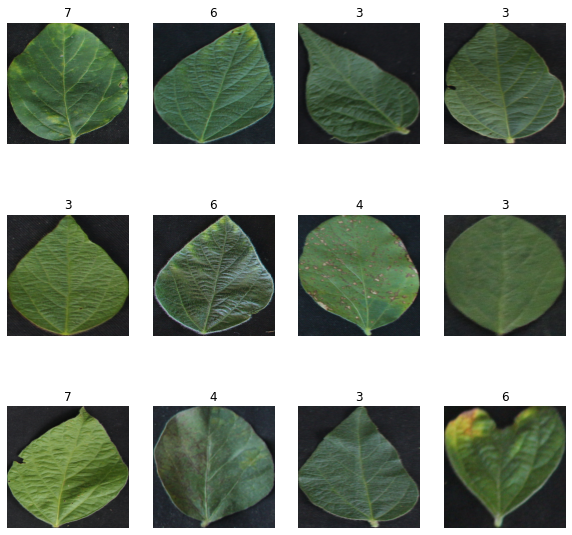

In [3]:
#Check dimensions of a single batch#
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

#Plot some of the images from a single random batch, with label of class#
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [4]:
len(dataset)

231

In [5]:
#Define function to split tensor data into training and test sets. Specify split here, used 80:20 for this#
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    test_size = int(test_split * ds_size)
    
    train_ds = ds.take(train_size)    
    test_ds = ds.skip(train_size).take(test_size)
    
    return train_ds, test_ds

In [6]:
#Split the data into training and testing#
train_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
#Resize and recale the images to all be the same#
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_WIDTH, IMAGE_HEIGHT),
  layers.experimental.preprocessing.Rescaling(1./255),
])

#Apply some data augmentations#
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.4, 0.2),
  layers.experimental.preprocessing.RandomZoom(0.5, 0.1),
  layers.experimental.preprocessing.RandomHeight(0.6)
])

In [8]:
#Apply augmentations to the training set#
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
input_shape = (BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
n_classes = 7

#Write and define the model#
model1 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model1.build(input_shape=input_shape)

model1.summary()

model1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 222, 222, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (64, 111, 111, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 109, 109, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 54, 54, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 52, 52, 64)         

In [10]:
#Lets run this thing (the model)#
history = model1.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/40


2023-04-07 13:12:45.245425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [14725]
	 [[{{node Placeholder/_0}}]]
2023-04-07 13:12:45.245959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_38' with dtype resource
	 [[{{node Placeholder/_38}}]]
2023-04-07 13:12:56.617992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 50 of 10000
2023-04-07 13:13:06.691944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 104 of 10000
2023-04-07 13:13:16.64933

184/184 [==============================] - 469s 2s/step - loss: 1.6646 - accuracy: 0.3927
Epoch 2/40
184/184 [==============================] - 413s 2s/step - loss: 1.3401 - accuracy: 0.5291
Epoch 3/40
184/184 [==============================] - 423s 2s/step - loss: 1.1380 - accuracy: 0.6060
Epoch 4/40
184/184 [==============================] - 427s 2s/step - loss: 1.0562 - accuracy: 0.6315
Epoch 5/40
184/184 [==============================] - 425s 2s/step - loss: 0.9178 - accuracy: 0.6719
Epoch 6/40
184/184 [==============================] - 419s 2s/step - loss: 0.8794 - accuracy: 0.6850
Epoch 7/40
184/184 [==============================] - 418s 2s/step - loss: 0.8156 - accuracy: 0.7135
Epoch 8/40
184/184 [==============================] - 426s 2s/step - loss: 0.7759 - accuracy: 0.7236
Epoch 9/40
184/184 [==============================] - 428s 2s/step - loss: 0.7555 - accuracy: 0.7285
Epoch 10/40
184/184 [==============================] - 430s 2s/step - loss: 0.7394 - accuracy: 0.7380


In [11]:
#Run the test data through the model#
scores = model1.evaluate(test_ds)

2023-04-07 17:59:34.622543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14725]
	 [[{{node Placeholder/_4}}]]
2023-04-07 17:59:34.623065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14725]
	 [[{{node Placeholder/_4}}]]
2023-04-07 17:59:44.839064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 57 of 10000
2023-04-07 17:59:54.858616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 118 of 10000
2023-04-07 18

46/46 [==============================] - 55s 369ms/step - loss: 0.3129 - accuracy: 0.8886


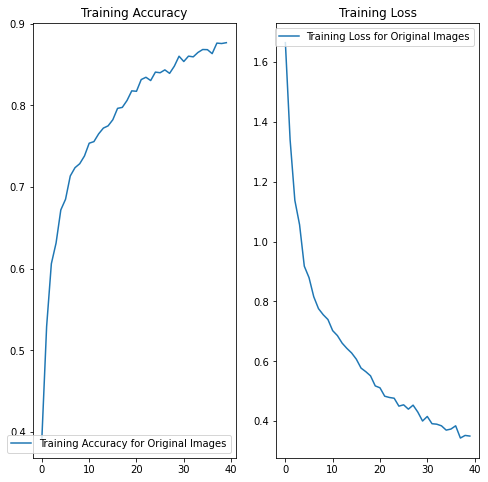

In [12]:
#Lets look at the accuracy and loss for training of model 1 (original images)#
#Assign accuracy and loss variables#
acc = history.history['accuracy']
loss = history.history['loss']

#Plot history of accuracy#
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy for Original Images')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

#Plot history of loss#
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss for Original Images')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [13]:
#Function to take a randome image, predict the disease class, and print it along with actual class and accuracy. Used below#
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model1.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

2023-04-07 18:00:42.047673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14725]
	 [[{{node Placeholder/_4}}]]
2023-04-07 18:00:42.048407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [14725]
	 [[{{node Placeholder/_0}}]]


first image to predict
actual label: 3
2/2 [==============================] - 1s 203ms/step
predicted label: 3
1/1 [==============================] - 0s 97ms/step


2023-04-07 18:00:42.639985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14725]
	 [[{{node Placeholder/_4}}]]
2023-04-07 18:00:42.640621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14725]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 28ms/step


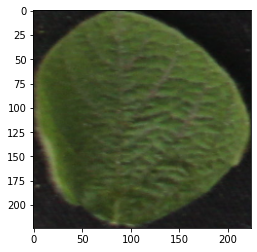

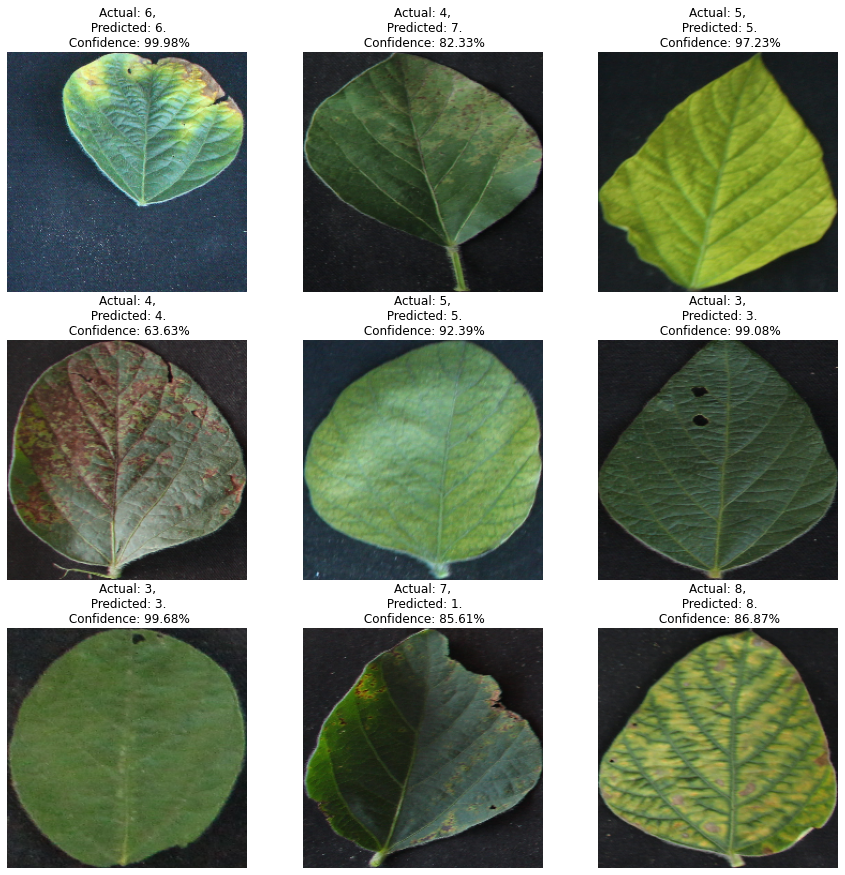

In [14]:
#Plot random images and view the actual and predicted class#
#One image at a time#
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model1.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

#Look at multiple images and give the prediction accuracy#
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model1, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

This marks the start of the model for the smallest cropped size of images: 224x224.

In [4]:
shutil.rmtree("/home/exouser/ME592_Spring2023/Homework/data/HW3/Leaf_images/224/.ipynb_checkpoints")

In [5]:
#Define some of the parameters used in the model#
BATCH_SIZE = 32
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
CHANNELS=3
EPOCHS=20

#Convert the images into a tensor dataframe#
dataset224 = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/exouser/ME592_Spring2023/Homework/data/HW3/Leaf_images/224",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

#Check that the number and names of classes is correct#
#If an ipynb checkpoint exists, use the code at the top of the notebook to remove, and then rerun this cell#
class_names = dataset224.class_names
class_names

Found 14725 files belonging to 7 classes.


['1', '3', '4', '5', '6', '7', '8']

2023-04-06 18:59:22.056760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [14725]
	 [[{{node Placeholder/_0}}]]
2023-04-06 18:59:22.057080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14725]
	 [[{{node Placeholder/_4}}]]
2023-04-06 18:59:22.185379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1472

(32, 224, 224, 3)
[3 3 5 5 2 1 1 2 5 1 4 2 1 2 1 0 4 4 5 5 1 4 4 4 5 0 2 5 0 1 0 1]


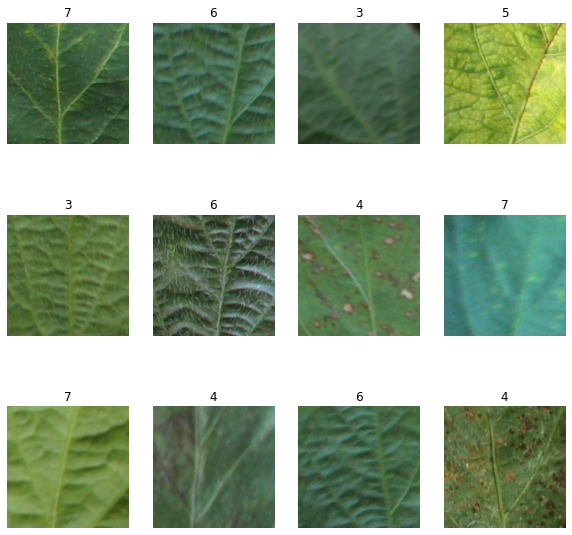

In [8]:
#Check dimensions of a single batch#
for image_batch, labels_batch in dataset224.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

#Plot some of the images from a single random batch, with label of class#
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset224.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
#Split the data into training and testing#
train_ds224, test_ds224 = get_dataset_partitions_tf(dataset224)

train_ds224 = train_ds224.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds224 = test_ds224.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#Apply augmentations to the training set#
train_ds224 = train_ds224.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
input_shape = (BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
n_classes = 7 #Seven different sets of images for the diseases and healthy#

#Write and define the model#
model224 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model224.build(input_shape=input_shape)

model224.summary()

model224.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 111, 111, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 54, 54, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 52, 64)         

In [11]:
#Lets run this thing (the model)#
history224 = model224.fit(
    train_ds224,
    batch_size=BATCH_SIZE,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20


2023-04-06 18:59:35.229602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_38' with dtype resource
	 [[{{node Placeholder/_38}}]]
2023-04-06 18:59:35.230150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_37' with dtype resource
	 [[{{node Placeholder/_37}}]]


368/368 [==============================] - 289s 775ms/step - loss: 1.5751 - accuracy: 0.4212
Epoch 2/20
368/368 [==============================] - 280s 761ms/step - loss: 1.3289 - accuracy: 0.5166
Epoch 3/20
368/368 [==============================] - 277s 753ms/step - loss: 1.2241 - accuracy: 0.5460
Epoch 4/20
368/368 [==============================] - 285s 774ms/step - loss: 1.1675 - accuracy: 0.5727
Epoch 5/20
368/368 [==============================] - 268s 728ms/step - loss: 1.1335 - accuracy: 0.5832
Epoch 6/20
368/368 [==============================] - 292s 794ms/step - loss: 1.0760 - accuracy: 0.6035
Epoch 7/20
368/368 [==============================] - 278s 756ms/step - loss: 1.0191 - accuracy: 0.6282
Epoch 8/20
368/368 [==============================] - 270s 734ms/step - loss: 0.9809 - accuracy: 0.6369
Epoch 9/20
368/368 [==============================] - 297s 806ms/step - loss: 0.9331 - accuracy: 0.6561
Epoch 10/20
368/368 [==============================] - 290s 787ms/step - lo

In [12]:
#Run the test data through the model#
scores224 = model224.evaluate(test_ds224)

2023-04-06 20:35:12.066758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14725]
	 [[{{node Placeholder/_4}}]]
2023-04-06 20:35:12.067223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14725]
	 [[{{node Placeholder/_4}}]]


92/92 [==============================] - 15s 134ms/step - loss: 0.6732 - accuracy: 0.7704


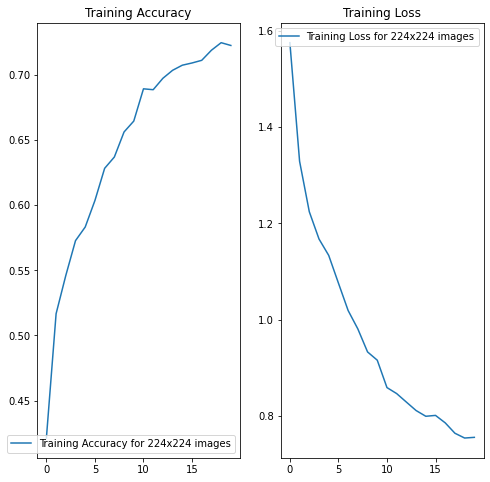

In [13]:
#Lets look at the accruacy and loss for training of model 224#
#Assign accuracy and loss variables#
acc224 = history224.history['accuracy']
loss224 = history224.history['loss']

#Plot history of accuracy#
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc224, label='Training Accuracy for 224x224 images')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

#Plot history of loss#
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss224, label='Training Loss for 224x224 images')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

2023-04-06 20:36:13.293415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14725]
	 [[{{node Placeholder/_4}}]]
2023-04-06 20:36:13.294121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14725]
	 [[{{node Placeholder/_4}}]]


first image to predict
actual label: 6
1/1 [==============================] - 0s 231ms/step
predicted label: 6
1/1 [==============================] - ETA: 0s

2023-04-06 20:36:13.588093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [14725]
	 [[{{node Placeholder/_0}}]]
2023-04-06 20:36:13.588580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14725]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 19ms/step


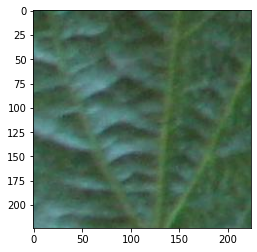

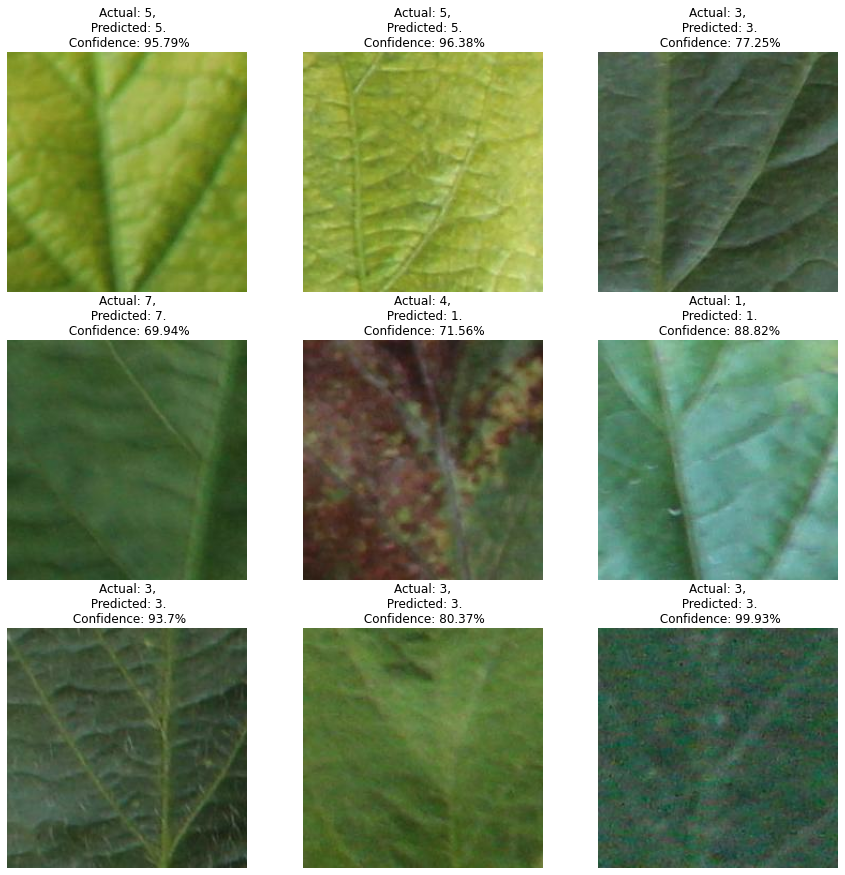

In [14]:
#Function to take a random image, predict the disease class, and print it along with actual class and accuracy. Used below#
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model224.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#Plot random images and view the actual and predicted class#
#One image at a time#
for images_batch, labels_batch in test_ds224.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model224.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

#Look at multiple images and give the prediction accuracy#
plt.figure(figsize=(15, 15))
for images, labels in test_ds224.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model224, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

This marks the start of the model training for the cropped images of size 448x448. 

In [16]:
shutil.rmtree("/home/exouser/ME592_Spring2023/Homework/data/HW3/Leaf_images/448/.ipynb_checkpoints")

In [2]:
#Define some of the parameters used in the model#
BATCH_SIZE = 32
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
CHANNELS=3
EPOCHS=20

#Convert the images into a tensor dataframe#
dataset448 = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/exouser/ME592_Spring2023/Homework/data/HW3/Leaf_images/448",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

#Check that the number and names of classes is correct#
#If an ipynb checkpoint exists, use the code at the top of the notebook to remove, and then rerun this cell#
class_names = dataset448.class_names
class_names

Found 14725 files belonging to 7 classes.


2023-04-06 20:38:00.942390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 20:38:00.942809: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


['1', '3', '4', '5', '6', '7', '8']

2023-04-06 20:38:39.713631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [14725]
	 [[{{node Placeholder/_0}}]]
2023-04-06 20:38:39.713929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [14725]
	 [[{{node Placeholder/_0}}]]
2023-04-06 20:38:39.847933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [147

(32, 224, 224, 3)
[3 3 5 5 2 1 1 2 5 1 4 2 1 2 1 0 4 4 5 5 1 4 4 4 5 0 2 5 0 1 0 1]


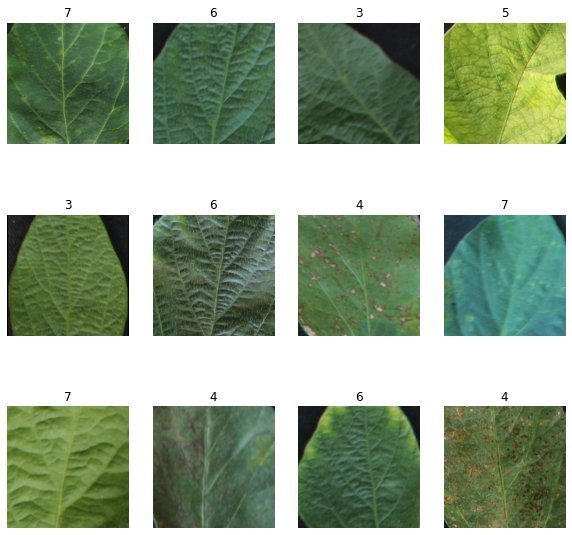

In [5]:
#Check dimensions of a single batch#
for image_batch, labels_batch in dataset448.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

#Plot some of the images from a single random batch, with label of class#
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset448.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
#Split the data into training and testing#
train_ds448, test_ds448 = get_dataset_partitions_tf(dataset448)

train_ds448 = train_ds448.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds448 = test_ds448.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#Apply augmentations to the training set#
train_ds448 = train_ds448.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
input_shape = (BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
n_classes = 7 #Seven different sets of images for the diseases and healthy#

#Write and define the model#
model448 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model448.build(input_shape=input_shape)

model448.summary()

model448.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 111, 111, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 54, 54, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 52, 64)         

In [8]:
#Lets run this thing (the model)#
history448 = model448.fit(
    train_ds448,
    batch_size=BATCH_SIZE,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20


2023-04-06 20:39:05.466852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_36' with dtype resource
	 [[{{node Placeholder/_36}}]]
2023-04-06 20:39:05.467352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_36' with dtype resource
	 [[{{node Placeholder/_36}}]]


368/368 [==============================] - 291s 777ms/step - loss: 1.5717 - accuracy: 0.4159
Epoch 2/20
368/368 [==============================] - 288s 783ms/step - loss: 1.2758 - accuracy: 0.5352
Epoch 3/20
368/368 [==============================] - 293s 795ms/step - loss: 1.1124 - accuracy: 0.5951
Epoch 4/20
368/368 [==============================] - 291s 789ms/step - loss: 1.0050 - accuracy: 0.6355
Epoch 5/20
368/368 [==============================] - 292s 794ms/step - loss: 0.9487 - accuracy: 0.6515
Epoch 6/20
368/368 [==============================] - 296s 804ms/step - loss: 0.9002 - accuracy: 0.6737
Epoch 7/20
368/368 [==============================] - 284s 771ms/step - loss: 0.8701 - accuracy: 0.6845
Epoch 8/20
368/368 [==============================] - 306s 831ms/step - loss: 0.8339 - accuracy: 0.6961
Epoch 9/20
368/368 [==============================] - 312s 846ms/step - loss: 0.7883 - accuracy: 0.7085
Epoch 10/20
368/368 [==============================] - 282s 765ms/step - lo

In [9]:
#Run the test data through the model#
scores448 = model448.evaluate(test_ds448)

2023-04-06 22:24:39.279550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14725]
	 [[{{node Placeholder/_4}}]]
2023-04-06 22:24:39.280154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [14725]
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - 17s 149ms/step - loss: 0.4645 - accuracy: 0.8329


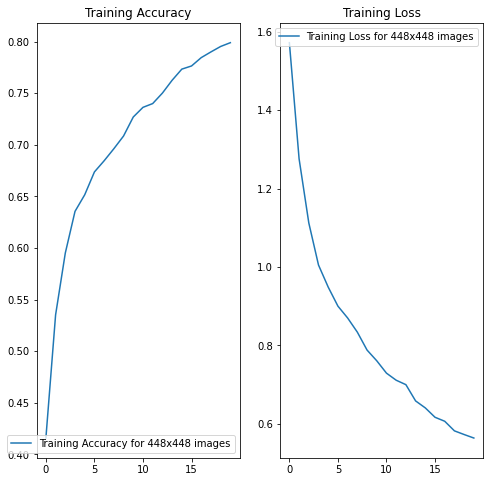

In [10]:
#Lets look at the accruacy and loss for training of model 224#
#Assign accuracy and loss variables#
acc448 = history448.history['accuracy']
loss448 = history448.history['loss']

#Plot history of accuracy#
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc448, label='Training Accuracy for 448x448 images')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

#Plot history of loss#
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss448, label='Training Loss for 448x448 images')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

2023-04-06 22:25:29.557188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14725]
	 [[{{node Placeholder/_4}}]]
2023-04-06 22:25:29.557686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [14725]
	 [[{{node Placeholder/_0}}]]


first image to predict
actual label: 3
1/1 [==============================] - 0s 250ms/step
predicted label: 3


2023-04-06 22:25:29.874484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [14725]
	 [[{{node Placeholder/_0}}]]
2023-04-06 22:25:29.874961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14725]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 25ms/step


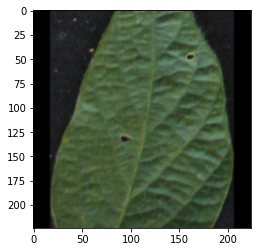

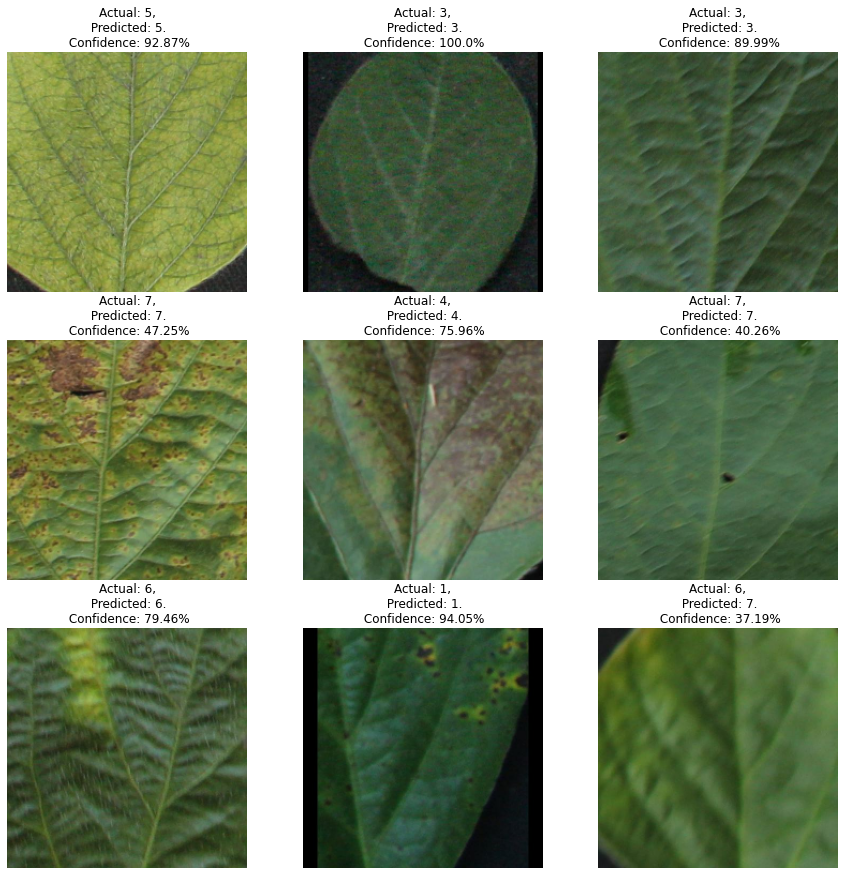

In [11]:
#Function to take a random image, predict the disease class, and print it along with actual class and accuracy. Used below#
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model448.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#Plot random images and view the actual and predicted class#
#One image at a time#
for images_batch, labels_batch in test_ds448.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model448.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

#Look at multiple images and give the prediction accuracy#
plt.figure(figsize=(15, 15))
for images, labels in test_ds448.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model448, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

This is the start of the code for building and testing the model for the 512x512 cropped images. 

In [13]:
shutil.rmtree("/home/exouser/ME592_Spring2023/Homework/data/HW3/Leaf_images/512/.ipynb_checkpoints")

In [14]:
#Define some of the parameters used in the model#
BATCH_SIZE = 32
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
CHANNELS=3
EPOCHS=20

#Convert the images into a tensor dataframe#
dataset512 = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/exouser/ME592_Spring2023/Homework/data/HW3/Leaf_images/512",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

#Check that the number and names of classes is correct#
#If an ipynb checkpoint exists, use the code at the top of the notebook to remove, and then rerun this cell#
class_names = dataset512.class_names
class_names

Found 14725 files belonging to 7 classes.


['1', '3', '4', '5', '6', '7', '8']

(32, 224, 224, 3)
[3 3 5 5 2 1 1 2 5 1 4 2 1 2 1 0 4 4 5 5 1 4 4 4 5 0 2 5 0 1 0 1]


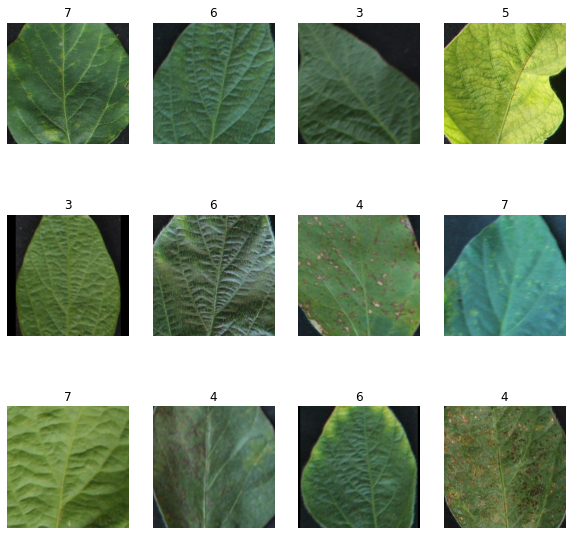

In [15]:
#Check dimensions of a single batch#
for image_batch, labels_batch in dataset512.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

#Plot some of the images from a single random batch, with label of class#
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset512.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [18]:
#Split the data into training and testing#
train_ds512, test_ds512 = get_dataset_partitions_tf(dataset512)

train_ds512 = train_ds512.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds512 = test_ds512.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#Apply augmentations to the training set#
train_ds512 = train_ds512.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
input_shape = (BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
n_classes = 7 #Seven different sets of images for the diseases and healthy#

#Write and define the model#
model512 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model512.build(input_shape=input_shape)

model512.summary()

model512.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_174 (Conv2D)         (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d_174 (MaxPooli  (32, 111, 111, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_175 (Conv2D)         (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_175 (MaxPooli  (32, 54, 54, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_176 (Conv2D)         (32, 52, 52, 64)        

In [20]:
#Lets run this thing (the model)#
history512 = model512.fit(
    train_ds512,
    batch_size=BATCH_SIZE,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
368/368 [==============================] - 245s 655ms/step - loss: 1.4730 - accuracy: 0.4463
Epoch 2/20
368/368 [==============================] - 244s 663ms/step - loss: 0.9834 - accuracy: 0.6469
Epoch 3/20
368/368 [==============================] - 241s 654ms/step - loss: 0.8756 - accuracy: 0.6861
Epoch 4/20
368/368 [==============================] - 244s 662ms/step - loss: 0.7865 - accuracy: 0.7144
Epoch 5/20
368/368 [==============================] - 242s 656ms/step - loss: 0.7522 - accuracy: 0.7304
Epoch 6/20
368/368 [==============================] - 245s 664ms/step - loss: 0.6751 - accuracy: 0.7544
Epoch 7/20
368/368 [==============================] - 245s 665ms/step - loss: 0.6306 - accuracy: 0.7740
Epoch 8/20
368/368 [==============================] - 237s 644ms/step - loss: 0.5884 - accuracy: 0.7848
Epoch 9/20
368/368 [==============================] - 238s 647ms/step - loss: 0.5786 - accuracy: 0.7943
Epoch 10/20
368/368 [==============================] - 239s 648m

In [21]:
#Run the test data through the model#
scores512 = model512.evaluate(test_ds512)

92/92 [==============================] - 14s 121ms/step - loss: 0.3866 - accuracy: 0.8662


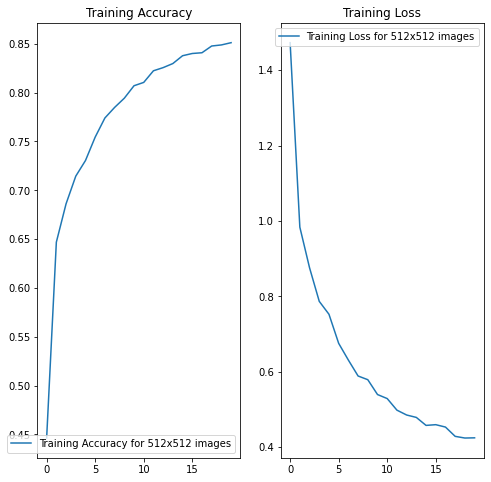

In [22]:
#Lets look at the accruacy and loss for training of model 224#
#Assign accuracy and loss variables#
acc512 = history512.history['accuracy']
loss512 = history512.history['loss']

#Plot history of accuracy#
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc512, label='Training Accuracy for 512x512 images')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

#Plot history of loss#
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss512, label='Training Loss for 512x512 images')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

first image to predict
actual label: 4
1/1 [==============================] - 0s 226ms/step
predicted label: 4
1/1 [==============================] - 0s 30ms/step


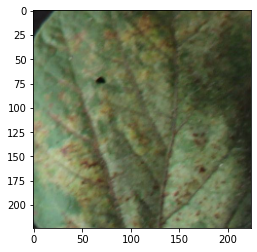

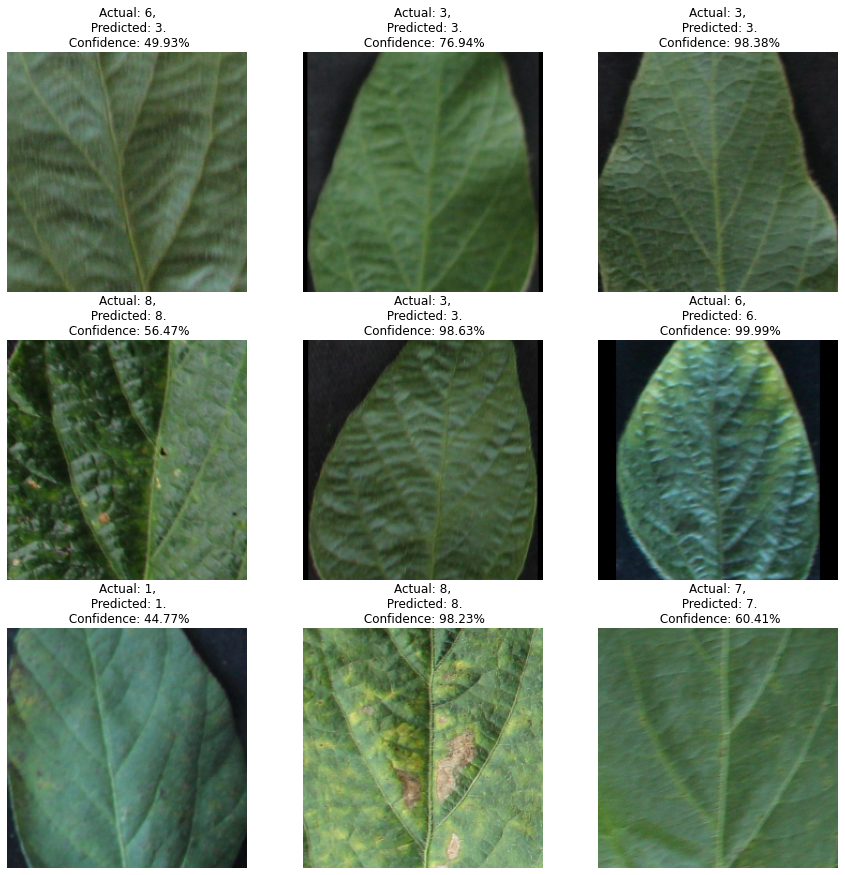

In [23]:
#Function to take a random image, predict the disease class, and print it along with actual class and accuracy. Used below#
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model512.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#Plot random images and view the actual and predicted class#
#One image at a time#
for images_batch, labels_batch in test_ds512.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model512.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

#Look at multiple images and give the prediction accuracy#
plt.figure(figsize=(15, 15))
for images, labels in test_ds512.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model512, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Hyperparameter optimization was done for the models. Due to the limited amount of time, optimization was only run on the model with a subset of the full images. Because of the length of this output and a constantly dying kernel, the output for this is not shown here. Instead results were recorded in another Jupyter Notebook, and some parameters were tuned in above models following this optimization. 

In [6]:
BATCH_SIZE = 32
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
CHANNELS=3
EPOCHS=5

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/exouser/ME592_Spring2023/Homework/data/HW3/Subs/Full",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

Found 1787 files belonging to 7 classes.


In [8]:
import math
train_size = 0.8 #0.8
training = math.trunc(len(dataset)*train_size)
print(training)

train_ds = dataset.take(training)
print(len(train_ds))

test_ds = dataset.skip(training)
print(len(test_ds))

val_size=0.1
#len(dataset)*val_size
validation = math.trunc(len(dataset)*val_size)
print(validation)

test_ds = test_ds.skip(validation)
print(len(test_ds))

# define the partitions into different datasets

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

# Create train, validation and test datasets
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print("Training dataset:", len(train_ds))
print("Validation dataset:",len(val_ds))
print("Testing dataset:",len(test_ds))

# Sampling the datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

44
44
12
5
7
Training dataset: 44
Validation dataset: 5
Testing dataset: 7


In [9]:
# Building the Model
# Creating a Layer for Resizing and Normalization

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_WIDTH, IMAGE_HEIGHT),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture

input_shape = (BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

model.summary()

# Compiling the Model
#from keras.optimizers import Ftrl
from keras.optimizers import Adam

model.compile(
#    optimizer=Ftrl(learning_rate=0.01), #ridicously large learning rate for testing 
    optimizer=Adam(lr=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.optimizer.get_config()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 111, 111, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 54, 54, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 52, 64)         

/home/exouser/.conda/envs/me592/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [10]:
# Hyperparameter optimization
# I couldn't make the learning rate tunning, but I think we can run the same model 
# with a couple learning rate, and choose which one looks better
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from tensorflow import keras
from sklearn.model_selection import GridSearchCV

#device = th.device("cuda" if th.cuda.is_available() else "cpu")
#device

# define your model architecture
def create_model():
    model = keras.models.Sequential([
        resize_and_rescale,
        layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax'),
    ])
    optimizer = Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# create KerasClassifier object with create_model function
model = KerasClassifier(build_fn=create_model, verbose=1)

# define hyperparameters to tune
param_grid = {
    'batch_size': [32, 64, 96], # change
    'epochs': [25, 40, 50] # change
}

# define cross-validation strategy
cv = 3

# create GridSearchCV object
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv=cv)

x_train = np.concatenate([x for x, y in train_ds], axis=0)
y_train = np.concatenate([y for x, y in train_ds], axis=0)
grid_result = grid.fit(x_train, y_train)

# print best hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# get best model
best_model = grid_result.best_estimator_

df = pd.DataFrame(grid_result.cv_results_)
df = df[['rank_test_score', 'param_batch_size', 'param_epochs', 'mean_test_score', 'std_test_score']]
df = df.sort_values('rank_test_score')
df


/tmp/ipykernel_3664/2060812365.py:40: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=1)
/home/exouser/.conda/envs/me592/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/25
30/30 [==============================] - 23s 721ms/step - loss: 1.9486 - accuracy: 0.1482
Epoch 2/25
30/30 [==============================] - 22s 716ms/step - loss: 1.9460 - accuracy: 0.1578
Epoch 3/25
30/30 [==============================] - 21s 701ms/step - loss: 1.9455 - accuracy: 0.1578
Epoch 4/25
30/30 [==============================] - 22s 723ms/step - loss: 1.9454 - accuracy: 0.1578
Epoch 5/25
30/30 [==============================] - 22s 730ms/step - loss: 1.9451 - accuracy: 0.1578
Epoch 6/25
30/30 [==============================] - 22s 726ms/step - loss: 1.9452 - accuracy: 0.1578
Epoch 7/25
30/30 [==============================] - 22s 724ms/step - loss: 1.9455 - accuracy: 0.1578
Epoch 8/25
30/30 [==============================] - 22s 720ms/step - loss: 1.9450 - accuracy: 0.1578
Epoch 9/25
30/30 [==============================] - 22s 730ms/step - loss: 1.9451 - accuracy: 0.1578
Epoch 10/25
30/30 [==============================] - 22s 739ms/step - loss: 1.9448 - accura

NameError: name 'pd' is not defined

In [11]:
import pandas as pd

df = pd.DataFrame(grid_result.cv_results_)
df = df[['rank_test_score', 'param_batch_size', 'param_epochs', 'mean_test_score', 'std_test_score']]
df = df.sort_values('rank_test_score')
df

rank_test_score param_batch_size param_epochs  mean_test_score  \
3                1               64           25         0.142765   
5                2               64           50         0.141331   
2                3               32           50         0.139192   
6                4               96           25         0.134939   
0                5               32           25         0.133525   
1                6               32           40         0.129972   
8                7               96           50         0.129264   
7                8               96           40         0.127118   
4                9               64           40         0.114351   

   std_test_score  
3        0.021235  
5        0.016140  
2        0.013370  
6        0.003879  
0        0.002783  
1        0.003484  
8        0.015031  
7        0.014683  
4        0.009635

Here starts the code for the object detector and leaf segmentation. The first part is from Ashlyn.

In [ ]:
#Turn XML bounding box files for each image into one long csv file
def xml_to_csv(path):
    """Iterates through all .xml files (generated by labelImg) in a given directory and combines them in a single Pandas datagrame.

    Parameters:
    ----------
    path : {str}
        The path containing the .xml files
    Returns
    -------
    Pandas DataFrame
        The produced dataframe
    """

    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                    int(root.find('size')[0].text),
                    int(root.find('size')[1].text),
                    member[0].text,
                    int(member[4][0].text),
                    int(member[4][1].text),
                    int(member[4][2].text),
                    int(member[4][3].text)
                    )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

inputDirTrain = r"/home/exouser/ME592_Spring2023/Homework/CanopyExtraction/images/train"
inputDirTest = r"/home/exouser/ME592_Spring2023/Homework/CanopyExtraction/images/test"
outputFileTrain = r"/home/exouser/ME592_Spring2023/Homework/CanopyExtraction/annotations/train_labels.csv"
outputFileTest = r"/home/exouser/ME592_Spring2023/Homework/CanopyExtraction/annotations/test_labels.csv"
        
def main(inputDir, outputFile):
    assert(os.path.isdir(inputDir))

    xml_df = xml_to_csv(inputDir)
    xml_df.to_csv(
        outputFile, index=None)
    print('Successfully converted xml to csv.')


if __name__ == '__main__':
    main(inputDirTrain, outputFileTrain)
    main(inputDirTest, outputFileTest)

In [ ]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf
import sys
sys.path.append("../../models/research")

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

In [ ]:
"""
Usage:

# Create train data:
python generate_tfrecord.py --label=<LABEL> --csv_input=<PATH_TO_ANNOTATIONS_FOLDER>/train_labels.csv  --output_path=<PATH_TO_ANNOTATIONS_FOLDER>/train.record

# Create test data:
python generate_tfrecord.py --label=<LABEL> --csv_input=<PATH_TO_ANNOTATIONS_FOLDER>/test_labels.csv  --output_path=<PATH_TO_ANNOTATIONS_FOLDER>/test.record
"""
#Turn the csv file into a record file

def class_text_to_int(row_label):
    if row_label == label:
        return 1
    else:
        None

def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
    with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    # check if the image format is matching with your images.
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def main(output_path, csv_input, img_path, label):
    writer = tf.io.TFRecordWriter(output_path)
    path = os.path.join(os.getcwd(), img_path)
    examples = pd.read_csv(csv_input)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path_ex = os.path.join(os.getcwd(), output_path)
    print('Successfully created the TFRecords: {}'.format(output_path_ex))

csv_input_train = r"/home/exouser/ME592_Spring2023/Homework/CanopyExtraction/annotations/train_labels.csv"
output_path_train = r"/home/exouser/ME592_Spring2023/Homework/CanopyExtraction/annotations/train.record"
label = "leaf"
img_path_train = r"/home/exouser/ME592_Spring2023/Homework/CanopyExtraction/images/train"

csv_input_test = r"/home/exouser/ME592_Spring2023/Homework/CanopyExtraction/annotations/test_labels.csv"
output_path_test = r"/home/exouser/ME592_Spring2023/Homework/CanopyExtraction/annotations/test.record"
img_path_test = r"/home/exouser/ME592_Spring2023/Homework/CanopyExtraction/images/test"

main(output_path = output_path_train, csv_input = csv_input_train, img_path = img_path_train, label = label)
main(output_path = output_path_test, csv_input = csv_input_test, img_path = img_path_test, label = label)

In [ ]:
# Copyright 2020 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

r"""Creates and runs TF2 object detection models. 
"""
import tensorflow.compat.v2 as tf
from object_detection import model_lib_v2

pipeline_config_path=str(r"C:\Users\ashly\Desktop\ME592_Temp\CanopyExtraction\models\ssd_resnet50_v1_fpn_640x640_coco17_tpu-8\pipeline.config")
num_train_steps=int(10)
eval_on_train_data=bool(False)
sample_1_of_n_eval_examples= int(0)#1
sample_1_of_n_eval_on_train_examples=int(0)#5
model_dir=str(r"C:\Users\ashly\Desktop\ME592_Temp\CanopyExtraction\models\ssd_resnet50_v1_fpn_640x640_coco17_tpu-8")
checkpoint_dir=str(None)

eval_timeout=int(3600)
use_tpu= bool(False)
tpu_name = str(None)
num_workers=int(1)
checkpoint_every_n=int(10)
record_summaries=bool(True)

def main(unused_argv):
  tf.config.set_soft_device_placement(True)

  if checkpoint_dir:
    model_lib_v2.eval_continuously(
        pipeline_config_path=pipeline_config_path,
        model_dir=model_dir,
        train_steps=num_train_steps,
        sample_1_of_n_eval_examples=sample_1_of_n_eval_examples,
        sample_1_of_n_eval_on_train_examples=(
            sample_1_of_n_eval_on_train_examples),
        checkpoint_dir=checkpoint_dir,
        wait_interval=300, timeout=eval_timeout)
  else:
    if use_tpu:
      # TPU is automatically inferred if tpu_name is None and
      # we are running under cloud ai-platform.
      resolver = tf.distribute.cluster_resolver.TPUClusterResolver(
          tpu_name)
      tf.config.experimental_connect_to_cluster(resolver)
      tf.tpu.experimental.initialize_tpu_system(resolver)
      strategy = tf.distribute.experimental.TPUStrategy(resolver)
    elif num_workers > 1:
      strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
    else:
      strategy = tf.compat.v2.distribute.MirroredStrategy()

    with strategy.scope():
      model_lib_v2.train_loop(
          pipeline_config_path=pipeline_config_path,
          model_dir=model_dir,
          train_steps=num_train_steps,
          use_tpu=use_tpu,
          checkpoint_every_n=checkpoint_every_n,
          record_summaries=record_summaries)

if __name__ == '__main__':
  tf.compat.v1.app.run()


Sam's version of detecting leaves.

In [ ]:
# This code takes two inputs folder_path and then at the bottom of the code with the cv2.imwrite() function. Put the folder path where
# you want to save the images at. 

import os
import cv2

folder_path = r"E:\ME 592\Assignment 3\idcdiseases"
file_paths = []

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    # Get the full file path by joining the folder path with the file name
    file_path = os.path.join(folder_path, filename)
    # Check if the file path is a file (not a directory)
    if os.path.isfile(file_path):
        # Add the file path to the list of file paths
        file_paths.append(file_path)

for img_path in file_paths:
    img = cv2.imread(img_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# Threshold the image to get only green colors
    lower_green = (36, 25, 25)
    upper_green = (70, 255, 255)
    mask = cv2.inRange(hsv, lower_green, upper_green)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw a bounding box around the largest green object
    if len(contours) > 0:
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cropped_img = img[y:y+h, x:x+w]
    hsv = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2HSV)
    lower_green = (36, 25, 25)
    upper_green = (70, 255, 255)

    mask = cv2.inRange(hsv, lower_green, upper_green)

    result = cv2.bitwise_and(cropped_img, cropped_img, mask=mask)

    gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Find contours in the binary image
    contours2, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Draw bounding boxes around the contours
    for i, cnt in enumerate(contours2):
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h > 12000 and w*h < 1700000:  
            roi = result[y:y+h, x:x+w]
            cv2.imwrite(r'C:\Users\samblair\Desktop\M E 592\Assignment 3\imgs\leaf{}.jpg'.format(i), roi)
            cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
